# Class 6: Advanced `pandas`

Currently, `pandas`' `Series` and `DataFrame` might seem to us as no more than tables with complicated indexing methods. In this lesson, we will learn more about what makes `pandas` so powerful and how we can use it to write efficient and readable code.

````{note}
Some of the features described below only work with pandas >= 1.0.0. Make sure you have the latest pandas installation when running this notebook. To check the version of your pandas (or any other package), import it and print its `__version__` attribute:
```python
>>> import pandas as pd
>>> print(pd.__version__)
'1.2.0'
```
````

## Missing Data

<div style="text-align:center"><img src="https://static.wikia.nocookie.net/lostpedia/images/1/16/Lost-season1.jpg/revision/latest/scale-to-width-down/300?cb=20070303221754" /></div>

The last question in the previous class pointed us to [working with missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html). But how and why does missing data occur?

One option is pandas' index alignment, the property that makes sure that each value will have the same index throughout the entire computation process.

In [29]:
import pandas as pd
import numpy as np


A = pd.Series([2, 4, 6], index=[0, 1, 2])
B = pd.Series([1, 3, 5], index=[1, 2, 3])
A + B

0    NaN
1    5.0
2    9.0
3    NaN
dtype: float64

The NaNs we have are what we call missing data - this is the way pandas represents it. We'll discuss about it in detail in a few moments.

The same thing occurs with DataFrames:

In [30]:
A = pd.DataFrame(np.random.randint(0, 20, (2, 2)),
                 columns=list('AB'))
A

,A,B
0,1,8
1,15,17


In [31]:
B = pd.DataFrame(np.random.randint(0, 10, (3, 3)),
                 columns=list('BAC'))
B

,B,A,C
0,4,8,4
1,1,1,2
2,1,4,8


In [32]:
new = A + B
print(new)
print(f"DTypes:\n{new.dtypes}")

      A     B   C
0   9.0  12.0 NaN
1  16.0  18.0 NaN
2   NaN   NaN NaN
DTypes:
A    float64
B    float64
C    float64
dtype: object


The DF's shape is the shape of the larger DF, and the "extra" row (index 2) was filled with NaNs. Since we have NaNs, the data type of the column is implicitly converted to a floating point type. To have integer DataFrames with NAs, we have to explicitly say we want them available. More on that later.

Another way to introduce missing data is through reindexing. If we "resample" our data we can achieve the following:

In [33]:
df = pd.DataFrame(np.random.randn(5, 3), index=['a', 'c', 'e', 'f', 'h'],
                  columns=['one', 'two', 'three'])
df

,one,two,three
a,0.369350,0.782736,1.875940
c,0.600203,1.002386,0.182499
e,1.759883,0.930489,1.564934
f,0.691812,-0.203926,-1.671613
h,0.889038,0.416180,0.506949


In [34]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2

,one,two,three
a,0.369350,0.782736,1.875940
b,NaN,NaN,NaN
c,0.600203,1.002386,0.182499
d,NaN,NaN,NaN
e,1.759883,0.930489,1.564934
f,0.691812,-0.203926,-1.671613
g,NaN,NaN,NaN
h,0.889038,0.416180,0.506949


As we mentioned, pandas is oriented towards handling missing data. In general one finds two approaches that one can take - either create a masking array around the DF, in which `False` values represent invalid entries, or create a _sentinel_ value that represents missing data, like -99999 or NaN.

These two approaches have their downsides - a boolean masks requires more memory, and perhaps longer computation times. The sentinel value might lead to use of inefficient data types and slow down computation as well.

Due to its reliance on numpy, pandas chose the path of sentinel values, with either `None` or NaN as the value.

### The `None` object

`None` is standard Python's null value. It can be found in many places in the language. For example, functions that don't have a `return` statement, implicitly return `None`. While `None` can be used as a missing data type, it's probably not the best choice.

In [35]:
vals1 = np.array([1, None, 3, 4])
vals1

array([1, None, 3, 4], dtype=object)

The `dtype` is `object`, because the best common type of `int`s and a `None` is a Python `object`. This slows down computation time on these arrays:

In [36]:
for dtype in ['object', 'int']:
    print("dtype =", dtype)
    %timeit np.arange(1E6, dtype=dtype).sum()
    print()

dtype = object
36.9 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

dtype = int
771 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)



If you recall from a couple of lessons ago, the "object" timings are very similar to those of standard lists, since indeed object arrays are pretty much identical to lists.

Another thing we can't do is aggregation:

In [37]:
vals1.sum()

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

### The `NaN` value

`NaN` is a special floating-point value recognized by all programming languages that conform to the IEEE standard (which means most of them). As we mentioned before, it forces the entire array to have a floating point type:

In [38]:
vals2 = np.array([1, np.nan, 3, 4])
vals2.dtype

dtype('float64')

Creating floating point arrays is very fast, so performance isn't hindered. NaN is sometimes described as a "data virus", since it infects objects it touches:

In [39]:
1 + np.nan

nan

In [40]:
0 * np.nan

nan

In [41]:
vals2.sum(), vals2.min(), vals2.max()  # runtime warnings (not shown here), not exceptions

(nan, nan, nan)

In [42]:
np.nan == np.nan

False

Numpy has nan-aware counterparts to many of its aggregation functions, which can work with NaNs correctly. They usually have the same name as their non-NaN sibling, but with the "nan" preface:

In [43]:
print(np.nansum(vals2))
print(np.nanmean(vals2))

8.0
2.6666666666666665


However, pandas objects account for NaNs in their calculations, as we'll soon see.

pandas can handle both `NaN` and `None` interchangeably:

In [44]:
ser = pd.Series([1, np.nan, 2, None])
ser

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

### The `NaT` value


When dealing with datetime values or indices, the missing value is represented as `NaT`, or not-a-time:
<div style="text-align:center"><img src="https://149366099.v2.pressablecdn.com/wp-content/uploads/2014/10/What-is-time.png" /></div>

In [45]:
df['timestamp'] = pd.Timestamp('20180101')
df

,one,two,three,timestamp
a,0.369350,0.782736,1.875940,2018-01-01
c,0.600203,1.002386,0.182499,2018-01-01
e,1.759883,0.930489,1.564934,2018-01-01
f,0.691812,-0.203926,-1.671613,2018-01-01
h,0.889038,0.416180,0.506949,2018-01-01


In [46]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2

,one,two,three,timestamp
a,0.369350,0.782736,1.875940,2018-01-01
b,NaN,NaN,NaN,NaT
c,0.600203,1.002386,0.182499,2018-01-01
d,NaN,NaN,NaN,NaT
e,1.759883,0.930489,1.564934,2018-01-01
f,0.691812,-0.203926,-1.671613,2018-01-01
g,NaN,NaN,NaN,NaT
h,0.889038,0.416180,0.506949,2018-01-01


### Operations and calculations with missing data

In [47]:
a = pd.DataFrame(np.random.random((5, 2)), columns=['one', 'two'])
a.iloc[1, 1] = np.nan
a

,one,two
0,0.065449,0.018906
1,0.434429,NaN
2,0.229545,0.586038
3,0.871537,0.783734
4,0.770619,0.293776


In [48]:
b = pd.DataFrame(np.random.random((6, 3)), columns=['one', 'two', 'three'])
b.iloc[2, 2] = np.nan
b

,one,two,three
0,0.640799,0.920508,0.211992
1,0.760239,0.297325,0.264362
2,0.058171,0.979130,NaN
3,0.294290,0.664070,0.890194
4,0.713352,0.555523,0.442812
5,0.373683,0.286472,0.541944


In [49]:
a + b

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,NaN
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,1.483972,NaN,0.849299
5,NaN,NaN,NaN


As we see, missing values propagate naturally through these arithmetic operations. Statistics also works:

In [50]:
(a + b).describe()
# Summation - NaNs are zero.
# If everything is NaN - the result is NaN as well.
# pandas' cumsum and cumprod ignore NaNs but preserve them in the resulting arrays.

,one,three,two
count,5.000000,0.0,4.000000
mean,0.967686,NaN,1.200421
std,0.471180,NaN,0.358539
min,0.287716,NaN,0.849299
25%,0.706248,NaN,0.916885
50%,1.165827,NaN,1.193609
75%,1.194669,NaN,1.477145
max,1.483972,NaN,1.565168


We can also receive a boolean mask of the NaNs in a dataframe:

In [51]:
mask = (a + b).isnull()  # also isna(), and the opposite .notnull()
mask

,one,three,two
0,False,True,False
1,False,True,True
2,False,True,False
3,False,True,False
4,False,True,False
5,True,True,True


#### Filling missing values

The simplest option is to use the `fillna` method:

In [52]:
summed = a + b
summed.iloc[4, 0] = np.nan
summed

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,NaN
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,NaN,NaN,0.849299
5,NaN,NaN,NaN


In [53]:
summed.fillna(0)

,one,three,two
0,0.706248,0.0,0.939414
1,1.194669,0.0,0.000000
2,0.287716,0.0,1.565168
3,1.165827,0.0,1.447803
4,0.000000,0.0,0.849299
5,0.000000,0.0,0.000000


In [54]:
summed.fillna('missing')  # changed dtype to "object"

,one,three,two
0,0.706248,missing,0.939414
1,1.194669,missing,missing
2,0.287716,missing,1.565168
3,1.165827,missing,1.447803
4,missing,missing,0.849299
5,missing,missing,missing


In [55]:
summed.fillna(method='pad')  # The NaN column remained the same, but values were propagated forward
# We can also use the "backfill" method to fill in values to the back

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,0.939414
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,1.165827,NaN,0.849299
5,1.165827,NaN,0.849299


In [56]:
summed.fillna(method='pad', limit=1)  # No more than one padded NaN in a row

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,0.939414
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,1.165827,NaN,0.849299
5,NaN,NaN,0.849299


In [57]:
summed.fillna(summed.mean())  # each column received its respective mean. The NaN column is untouched.

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,1.200421
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,0.838615,NaN,0.849299
5,0.838615,NaN,1.200421


#### Dropping missing values

We've already seen in the short exercise the `dropna` method, that allows us to drop missing values:

In [58]:
summed

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,NaN
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,NaN,NaN,0.849299
5,NaN,NaN,NaN


In [59]:
filled = summed.fillna(summed.mean())
filled

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,1.200421
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,0.838615,NaN,0.849299
5,0.838615,NaN,1.200421


In [60]:
filled.dropna(axis=1)  # each column containing NaN is dropped

,one,two
0,0.706248,0.939414
1,1.194669,1.200421
2,0.287716,1.565168
3,1.165827,1.447803
4,0.838615,0.849299
5,0.838615,1.200421


In [61]:
filled.dropna(axis=0)  # each row containing a NaN is dropped

,one,three,two


#### [Interpolation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

The last way to to fill in missing values is through interpolation.

The default interpolation methods perform linear interpolation on the data, based on its ordinal index:

In [62]:
summed

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,NaN
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,NaN,NaN,0.849299
5,NaN,NaN,NaN


In [63]:
summed.interpolate()  # notice all the details in the interpolation of the three columns

,one,three,two
0,0.706248,NaN,0.939414
1,1.194669,NaN,1.252291
2,0.287716,NaN,1.565168
3,1.165827,NaN,1.447803
4,1.165827,NaN,0.849299
5,1.165827,NaN,0.849299


We can also interpolate with the actual index values in mind:

In [64]:
# Create "missing" index
timeindex = pd.Series(['1/1/2018', '1/4/2018', '1/5/2018', '1/7/2018', '1/8/2018'])
timeindex = pd.to_datetime(timeindex)
data_to_interp = [1, np.nan, 5, np.nan, 8]
df_to_interp = pd.DataFrame(data_to_interp, index=timeindex)
df_to_interp

,0
2018-01-01,1.0
2018-01-04,NaN
2018-01-05,5.0
2018-01-07,NaN
2018-01-08,8.0


In [65]:
df_to_interp.interpolate()  # the index values aren't taken into account

,0
2018-01-01,1.0
2018-01-04,3.0
2018-01-05,5.0
2018-01-07,6.5
2018-01-08,8.0


In [66]:
df_to_interp.interpolate(method='index')  # notice how the data obtains the "right" values

,0
2018-01-01,1.0
2018-01-04,4.0
2018-01-05,5.0
2018-01-07,7.0
2018-01-08,8.0


Pandas has many other interpolation methods, based on SciPy's. 

In [67]:
df_inter_2 = pd.DataFrame({'A': [1, 2.1, np.nan, 4.7, 5.6, 6.8],
                           'B': [.25, np.nan, np.nan, 4, 12.2, 14.4]})
df_inter_2

,A,B
0,1.0,0.25
1,2.1,NaN
2,NaN,NaN
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [68]:
df_inter_2.interpolate(method='polynomial', order=2)

,A,B
0,1.000000,0.250000
1,2.100000,-2.703846
2,3.451351,-1.453846
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


### Missing Values in Non-Float Columns

Starting from pandas v1.0.0 pandas gained support for NaN values in non-float columns. This feature is a bit experimental currently, so the default behavior still converts integers to floats for example, but the support is there if you know where to look. By default:

In [69]:
nanint = pd.Series([1, 2, np.nan, 4])
nanint  # the result has a dtype of float64 even though all numbers are integers.

0    1.0
1    2.0
2    NaN
3    4.0
dtype: float64

We can try to force pandas' hand here, but it won't work:

In [70]:
nanint = pd.Series([1, 2, np.nan, 4], dtype="int32")

ValueError: cannot convert float NaN to integer

To our rescue comes the new `pd.Int32Dtype`:

In [71]:
nanint = pd.Series([1, 2, np.nan, 4], dtype="Int32")
nanint

0       1
1       2
2    <NA>
3       4
dtype: Int32

It worked! We have a series with integers and a missing value! Notice the changes we had to made:
1. The `NaN` is `<NA>` now. It's actually a new type of `NaN` called `pd.NA`.
2. The data type had to be mentioned explictly, meaning that the conversion will work only if we know in advance that we'll have NA values.
3. The data type is `Int32`. It's CamelCase and it's actually a class underneath. Standard datatypes are lowercase.

Caveats aside, this is definitely useful for scientists who sometimes have integer values and do not want to convert them to float to supports NAs.

## Categorical Data

I'd like to discuss one more data type - [__categorical__ data](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html). Most data we've been working on is 'quantitative' in its nature i.e. integers and real numbers can hold (in general terms) any value. But some data can only have one of a specific set, or categories, of data. For example, if we have a column which marks the weekday, then it can obviously only be one of seven options. Same for boolean data, colors, and other examples. These data columns should be marked as "categorical" to reduce memory consumption and improve performance. It also tells the code readers more about the nature of that data column.

The easiest way to create a categorical variable is to declare it as such, or to convert as existing column to a categorical data type:

In [72]:
s = pd.Series(["a", "b", "c", "a"], dtype="category")
s

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): ['a', 'b', 'c']

In [73]:
df = pd.DataFrame({"A": ["a", "b", "c", "a"]})
df["B"] = df["A"].astype("category")
print("DataFrame:\n",df)
print("Columns' data types:\n",df.dtypes)

DataFrame:
    A  B
0  a  a
1  b  b
2  c  c
3  a  a
Columns' data types:
 A      object
B    category
dtype: object


We can also force order between our categories, or force specific categories on our data, using the special CategoricalDtype (which we won't show).

As we said, memory usage is reduced when working with categorical data:

In [74]:
df_obj = pd.DataFrame({'a': np.random.random(10_000), 'b': ['a'] * 10_000})
df_obj

,a,b
0,0.040435,a
1,0.665366,a
2,0.076690,a
3,0.346332,a
4,0.019470,a
...,...,...
9995,0.576298,a
9996,0.057178,a
9997,0.768620,a
9998,0.233202,a


In [75]:
df_cat = pd.DataFrame({'a': df_obj['a'], 'b': df_obj['b'].astype('category')})
df_cat

,a,b
0,0.040435,a
1,0.665366,a
2,0.076690,a
3,0.346332,a
4,0.019470,a
...,...,...
9995,0.576298,a
9996,0.057178,a
9997,0.768620,a
9998,0.233202,a


In [76]:
df_obj.memory_usage()

Index      128
a        80000
b        80000
dtype: int64

In [77]:
df_cat.memory_usage()

Index      128
a        80000
b        10116
dtype: int64

A factor of 8 in memory reduction.

## [Hierarchical Indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)

Last time we mentioned that while a DataFrame is inherently a 2D object, it can contain multi-dimensional data. The way a DataFrame (and a Series) does that is with Hierarchical Indexing, or sometimes Multi-Indexing.

After the deprecation of `pd.Panel`, this is the only remaining way to represent data of higher dimensions in pandas, making it a very useful tool for data science.

### Simple Example - Temperature in a Grid

Let's assume I wish to represent points on a 2D grid, perhaps inside a square, that represent the temperature in different locations around this grid. The obvious way to do this is to define a set of two coordinates, $(x, y)$, which point to a specific location inside my square. These two coordinates should also have a value attached to them - the temperature. A list of such coordinates can be a simple Series:

In [78]:
values = np.array([1.2, 0.8, 3.1, 0.1, 0.05, 1, 1.4, 2.1, 2.9])
coords = [('r0', 'c0'), ('r0', 'c1'), ('r0', 'c2'), 
          ('r1', 'c0'), ('r1', 'c1'), ('r1', 'c2'), 
          ('r2', 'c0'), ('r2', 'c1'), ('r2', 'c2')]  # r is row, c is column
points = pd.Series(values, index=coords, name='temperature')
points

(r0, c0)    1.20
(r0, c1)    0.80
(r0, c2)    3.10
(r1, c0)    0.10
(r1, c1)    0.05
(r1, c2)    1.00
(r2, c0)    1.40
(r2, c1)    2.10
(r2, c2)    2.90
Name: temperature, dtype: float64

It is important we understand that this is a series because _the data is one-dimensional_. The actual data is contained in that rightmost column, a one-dimensional array. We do have two coordinates for each point, but the data itself - the temperature - is one-dimensional.

Currently the index is a simple tuple of coordinates. It's a single column, containing tuples. Pandas can help us to index this data in a more intuitive manner, using a MultiIndex object.

In [79]:
mindex = pd.MultiIndex.from_tuples(coords)
mindex

MultiIndex([('r0', 'c0'),
            ('r0', 'c1'),
            ('r0', 'c2'),
            ('r1', 'c0'),
            ('r1', 'c1'),
            ('r1', 'c2'),
            ('r2', 'c0'),
            ('r2', 'c1'),
            ('r2', 'c2')],
           )

We received something which looks quite similar to the list of tuples we had before, but it's a [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) instance. Let's see how it helps us by `reindex`ing our data with it:

In [80]:
points = points.reindex(mindex)
points

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
Name: temperature, dtype: float64

This looks good. Each index level is represented by a column, with the data being the last one. The "missing" values indicate that the value in that cell is the same as the value above it.

You might have assumed that accessing the data now is much more intuitive. Let's look at the values of all the points in the first row, `r0`:

In [81]:
points.loc['r0', :]  # .loc() is label-based indexing

r0  c0    1.2
    c1    0.8
    c2    3.1
Name: temperature, dtype: float64

Or the values of points in the second column:

In [82]:
points.loc[:, 'c1']

r0    0.80
r1    0.05
r2    2.10
Name: temperature, dtype: float64

In [83]:
points.loc[:, :, :]  # all values - each level of the index has its own colon (:)

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
Name: temperature, dtype: float64

Notice that `.iloc` disregards the MultiIndex, treating our data as a simple one-dimensional vector (as it actually is):

In [84]:
points.iloc[6]
# points.iloc[0, 1]  # ERRORS

1.4

Besides making the syntax cleaner, these slicing operations are as efficient as their single-dimension counterparts.

It should be clear that a MultiIndex can have more than two levels. Modelling a 3D cube (with the temperatures inside it) is as easy as:

In [85]:
values3d = np.array([1.2, 0.8, 
                     3.1, 0.1, 
                     0.05, 1, 
                     1.4, 2.1, 
                     2.9, 0.3,
                     2.4, 1.9])
# 3D coordinates with a shape of (r, c, z) = (3, 2, 2)
coords3d = [('r0', 'c0', 'z0'), ('r0', 'c0', 'z1'), 
            ('r0', 'c1', 'z0'), ('r0', 'c1', 'z1'),
            ('r1', 'c0', 'z0'), ('r1', 'c0', 'z1'),
            ('r1', 'c1', 'z0'), ('r1', 'c1', 'z1'), 
            ('r2', 'c0', 'z0'), ('r2', 'c0', 'z1'),
            ('r2', 'c1', 'z0'), ('r2', 'c1', 'z1')]  # we'll soon see an easier way to create this index
cube = pd.Series(values3d, index=pd.MultiIndex.from_tuples(coords3d), name='temp_cube')
cube

r0  c0  z0    1.20
        z1    0.80
    c1  z0    3.10
        z1    0.10
r1  c0  z0    0.05
        z1    1.00
    c1  z0    1.40
        z1    2.10
r2  c0  z0    2.90
        z1    0.30
    c1  z0    2.40
        z1    1.90
Name: temp_cube, dtype: float64

We can even name the individual levels, which helps with some slicing operations we'll see below:

In [86]:
cube.index.names = ['x', 'y', 'z']
cube

x   y   z 
r0  c0  z0    1.20
        z1    0.80
    c1  z0    3.10
        z1    0.10
r1  c0  z0    0.05
        z1    1.00
    c1  z0    1.40
        z1    2.10
r2  c0  z0    2.90
        z1    0.30
    c1  z0    2.40
        z1    1.90
Name: temp_cube, dtype: float64

Again, you have to remember that this is one-dimensional data, with a three-dimensional index. In statistical term, we might term the indices a fixed, independent categorical variable, while the values are the dependent variable. Pandas actually has a `CategoricalIndex` object which you'll meet in some future HW.

### More on extra dimensions

In the previous square example, it's very appealing to ditch the MultiIndex altogether and just work with a DataFrame, or even a simple numpy array. This is because the two indices represented rows and columns. A quick way to turn one representation into the other is the [`stack()`\\`unstack()`](https://pandas.pydata.org/docs/user_guide/reshaping.html) method:

In [87]:
points.index.names = ['rows', 'columns']
points

rows  columns
r0    c0         1.20
      c1         0.80
      c2         3.10
r1    c0         0.10
      c1         0.05
      c2         1.00
r2    c0         1.40
      c1         2.10
      c2         2.90
Name: temperature, dtype: float64

In [88]:
pts_df = points.unstack()
pts_df

columns,c0,c1,c2
rows,,,
r0,1.2,0.80,3.1
r1,0.1,0.05,1.0
r2,1.4,2.10,2.9


In [89]:
pts_df.stack()  # back to a series

rows  columns
r0    c0         1.20
      c1         0.80
      c2         3.10
r1    c0         0.10
      c1         0.05
      c2         1.00
r2    c0         1.40
      c1         2.10
      c2         2.90
dtype: float64

If we want to turn the indices into "real" columns, we can use the `reset_index()` method:

In [90]:
pts_df_reset = points.reset_index()
pts_df_reset

,rows,columns,temperature
0,r0,c0,1.20
1,r0,c1,0.80
2,r0,c2,3.10
3,r1,c0,0.10
4,r1,c1,0.05
5,r1,c2,1.00
6,r2,c0,1.40
7,r2,c1,2.10
8,r2,c2,2.90


So why bother with these (you haven't seen nothing yet) complicated multi-indices?

As you might have guessed, adding data points, i.e. increasing the dimensionality of the data, is very easy and intuitive. Data remains aligned through addition and deletion of data. Moreover, treating these categorical variables as an index can help the mental modeling of the problem, especially when you wish to perform statistical modeling with your analysis.

If you're not convinced yet, I'm sure that in a couple of examples you'll see their true power unfold.
<div style="text-align:center"><img src="https://media1.tenor.com/images/f4f1826873b424a2aedd57432b48e2fc/tenor.gif?itemid=12243212" /></div>


### Constructing a MultiIndex

Creating a hierarchical index can be done in several ways:

In [91]:
pd.MultiIndex.from_arrays([['a', 'a', 'b', 'b'], [1, 2, 1, 2]])

MultiIndex([('a', 1),
            ('a', 2),
            ('b', 1),
            ('b', 2)],
           )

In [92]:
pd.MultiIndex.from_tuples([('a', 1), ('a', 2), ('b', 1), ('b', 2)])

MultiIndex([('a', 1),
            ('a', 2),
            ('b', 1),
            ('b', 2)],
           )

In [93]:
pd.MultiIndex.from_product([['a', 'b'], [1, 2]])  # Cartesian product

MultiIndex([('a', 1),
            ('a', 2),
            ('b', 1),
            ('b', 2)],
           )

The most common way to construct a MultiIndex, though, is to add to the existing index one of the columns of the DataFrame. We'll see how it's done below.

Another important note is that with DataFrames, the column and row index is symmetric. In effect this means that  the columns could also contain a MultiIndex:

In [94]:
index = pd.MultiIndex.from_product([[2013, 2014], [1, 2]],
                                   names=['year', 'visit'])
columns = pd.MultiIndex.from_product([['Bob', 'Guido', 'Sue'], ['HR', 'Temp']],
                                     names=['subject', 'type'])

# mock some data
data = np.round(np.random.randn(4, 6), 1)
data[:, ::2] *= 10
data += 37

# create the DataFrame
health_data = pd.DataFrame(data, index=index, columns=columns)
health_data

subject      Bob       Guido         Sue      
type          HR  Temp    HR  Temp    HR  Temp
year visit                                    
2013 1      36.0  35.2  37.0  36.5  43.0  36.1
     2      55.0  38.6  37.0  39.0  20.0  36.2
2014 1      26.0  37.1  44.0  36.1  22.0  37.6
     2      32.0  37.3  33.0  35.3  47.0  37.6

This sometimes might seem too much, and so usually people prefer to keep the column index as a simple list of names, moving any nestedness to the row index. This is due to the fact that usually columns represent the measured dependent variable.

In [95]:
index = pd.MultiIndex.from_product([[2013, 2014], [1, 2], ['Bob', 'Guido', 'Sue']],
                                   names=['year', 'visit', 'subject'])
columns = ['HR', 'Temp']

# mock some data
data = np.round(np.random.randn(12, 2), 1)
data[:, ::2] *= 10
data += 37

# create the DataFrame
health_data_row = pd.DataFrame(data, index=index, columns=columns)
health_data_row

HR  Temp
year visit subject            
2013 1     Bob      43.0  35.2
           Guido    28.0  37.3
           Sue      47.0  37.4
     2     Bob      35.0  37.6
           Guido    47.0  36.3
           Sue      28.0  36.7
2014 1     Bob      39.0  36.1
           Guido    50.0  34.5
           Sue      31.0  36.7
     2     Bob      26.0  38.0
           Guido    34.0  36.0
           Sue      55.0  36.5

#### Creating a MultiIndex from a data column

While all of the above methods work, and could be useful sometimes, the most common method of creating an index is from an existing data column. 

In [96]:
location = ['AL', 'AL', 'NY', 'NY', 'NY', 'VA']
day = ['SUN', 'SUN', 'TUE', 'WED', 'SAT', 'SAT']
temp = [12.3, 14.1, 21.3, 20.9, 18.8, 16.5]
humidity = [31, 45, 41, 41, 49, 52]
states = pd.DataFrame(dict(location=location, day=day, 
                           temp=temp, humidity=humidity))
states

,location,day,temp,humidity
0,AL,SUN,12.3,31
1,AL,SUN,14.1,45
2,NY,TUE,21.3,41
3,NY,WED,20.9,41
4,NY,SAT,18.8,49
5,VA,SAT,16.5,52


In [97]:
states.set_index(['day'])

,location,temp,humidity
day,,,
SUN,AL,12.3,31
SUN,AL,14.1,45
TUE,NY,21.3,41
WED,NY,20.9,41
SAT,NY,18.8,49
SAT,VA,16.5,52


In [98]:
states.set_index(['day', 'location'])

temp  humidity
day location                
SUN AL        12.3        31
    AL        14.1        45
TUE NY        21.3        41
WED NY        20.9        41
SAT NY        18.8        49
    VA        16.5        52

In [99]:
states.set_index(['day', 'location'], append=True)

,,,temp,humidity
,day,location,,
0,SUN,AL,12.3,31
1,SUN,AL,14.1,45
2,TUE,NY,21.3,41
3,WED,NY,20.9,41
4,SAT,NY,18.8,49
5,SAT,VA,16.5,52


In [100]:
states.set_index([['i', 'ii', 'iii', 'iv', 'v', 'vi'], 'day'])

,,location,temp,humidity
,day,,,
i,SUN,AL,12.3,31
ii,SUN,AL,14.1,45
iii,TUE,NY,21.3,41
iv,WED,NY,20.9,41
v,SAT,NY,18.8,49
vi,SAT,VA,16.5,52


### Indexing and Slicing a MultiIndex

We'll use these DFs as an example:

In [101]:
health_data

subject      Bob       Guido         Sue      
type          HR  Temp    HR  Temp    HR  Temp
year visit                                    
2013 1      36.0  35.2  37.0  36.5  43.0  36.1
     2      55.0  38.6  37.0  39.0  20.0  36.2
2014 1      26.0  37.1  44.0  36.1  22.0  37.6
     2      32.0  37.3  33.0  35.3  47.0  37.6

In [102]:
health_data_row

HR  Temp
year visit subject            
2013 1     Bob      43.0  35.2
           Guido    28.0  37.3
           Sue      47.0  37.4
     2     Bob      35.0  37.6
           Guido    47.0  36.3
           Sue      28.0  36.7
2014 1     Bob      39.0  36.1
           Guido    50.0  34.5
           Sue      31.0  36.7
     2     Bob      26.0  38.0
           Guido    34.0  36.0
           Sue      55.0  36.5

If all we wish to do is to examine a column, indexing is very easy. Don't forget the DataFrame as dictionary analogy:

In [103]:
health_data['Guido']  # works for the column MultiIndex as expected

type          HR  Temp
year visit            
2013 1      37.0  36.5
     2      37.0  39.0
2014 1      44.0  36.1
     2      33.0  35.3

In [104]:
health_data_row['HR']  # that's a Series!

year  visit  subject
2013  1      Bob        43.0
             Guido      28.0
             Sue        47.0
      2      Bob        35.0
             Guido      47.0
             Sue        28.0
2014  1      Bob        39.0
             Guido      50.0
             Sue        31.0
      2      Bob        26.0
             Guido      34.0
             Sue        55.0
Name: HR, dtype: float64

In [105]:
# Accessing single elements is also pretty straight-forward
health_data_row.loc[2013, 1, 'Guido']  # index triplet

HR      28.0
Temp    37.3
Name: (2013, 1, Guido), dtype: float64

In [106]:
# We can even slice easily using the first MultiIndex (year in our case)
health_data_row.loc[2013:2017]  # 2017 doesn't exist, but Python's slicing rules prevent an exception here
# health_data_row.loc[1]  # doesn't work

HR  Temp
year visit subject            
2013 1     Bob      43.0  35.2
           Guido    28.0  37.3
           Sue      47.0  37.4
     2     Bob      35.0  37.6
           Guido    47.0  36.3
           Sue      28.0  36.7
2014 1     Bob      39.0  36.1
           Guido    50.0  34.5
           Sue      31.0  36.7
     2     Bob      26.0  38.0
           Guido    34.0  36.0
           Sue      55.0  36.5

Slicing is a bit more difficult when we want to take into account all available indices. This is due to the possible conflicts between the different indices and the columns.

Assuming we want to look at all the years, with all the visits, only by Bob - we would want to write something like this:

In [107]:
health_data_row.loc[(:, :, 'Bob'), :]  # doesn't work

SyntaxError: invalid syntax (<ipython-input-107-55ad5b04417a>, line 1)

This pickle is solved in two possible ways:

First option - the [slice](https://www.programiz.com/python-programming/methods/built-in/slice) object


In [108]:
bobs_data = (slice(None), slice(None), 'Bob')  # all years, all visits, of Bob
health_data_row.loc[bobs_data, 'HR']
# arr[slice(None), 1] is the same as arr[:, 1]

year  visit  subject
2013  1      Bob        43.0
      2      Bob        35.0
2014  1      Bob        39.0
      2      Bob        26.0
Name: HR, dtype: float64

In [109]:
row_idx = (slice(None), slice(None), slice('Bob', 'Guido'))  # all years, all visits, Bob + Guido
health_data_row.loc[row_idx, 'HR']

year  visit  subject
2013  1      Bob        43.0
             Guido      28.0
      2      Bob        35.0
             Guido      47.0
2014  1      Bob        39.0
             Guido      50.0
      2      Bob        26.0
             Guido      34.0
Name: HR, dtype: float64

 Second option - the [IndexSlice](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.IndexSlice.html) object

In [110]:

idx = pd.IndexSlice
health_data_row.loc[idx[:, :, 'Bob'], :]  # very close to the naive implementation

HR  Temp
year visit subject            
2013 1     Bob      43.0  35.2
     2     Bob      35.0  37.6
2014 1     Bob      39.0  36.1
     2     Bob      26.0  38.0

In [111]:
idx2 = pd.IndexSlice
health_data_row.loc[idx2[2013:2015, 1, 'Bob':'Guido'], 'Temp']

year  visit  subject
2013  1      Bob        35.2
             Guido      37.3
2014  1      Bob        36.1
             Guido      34.5
Name: Temp, dtype: float64

There's one more way to index into a MultiIndex, which is very straight-forward and explicit when you're looking for specific values: The [cross-section](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html) - 

In [112]:
# Third option - the cross-section - returns specific values
health_data_row.xs(key=(2013, 1), level=('year', 'visit'))

,HR,Temp
subject,,
Bob,43.0,35.2
Guido,28.0,37.3
Sue,47.0,37.4


#### Small caveat - unsorted indices

Having an unsorted index in your MultiIndex might make the interpreter pop a few exceptions at you:

In [113]:
# char index in unsorted
index = pd.MultiIndex.from_product([['a', 'c', 'b'], [1, 2]])
data = pd.Series(np.random.rand(6), index=index)
data.index.names = ['char', 'int']
data

char  int
a     1      0.825630
      2      0.463276
c     1      0.239827
      2      0.032947
b     1      0.411629
      2      0.964536
dtype: float64

In [114]:
data['a':'b']

UnsortedIndexError: 'Key length (1) was greater than MultiIndex lexsort depth (0)'

`lexsort` means "lexicography-sorted", or sorted by either number or letter. Sorting an index is done with the [`sort_index()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_index.html) method:

In [115]:
data.sort_index(inplace=True)
print(data)
print(data['a':'b'])  # now it works

char  int
a     1      0.825630
      2      0.463276
b     1      0.411629
      2      0.964536
c     1      0.239827
      2      0.032947
dtype: float64
char  int
a     1      0.825630
      2      0.463276
b     1      0.411629
      2      0.964536
dtype: float64


### Data Aggregation

Data aggregation using a MultiIndex is amazingly simple:

In [116]:
states

,location,day,temp,humidity
0,AL,SUN,12.3,31
1,AL,SUN,14.1,45
2,NY,TUE,21.3,41
3,NY,WED,20.9,41
4,NY,SAT,18.8,49
5,VA,SAT,16.5,52


In [117]:
states.set_index(['location', 'day'], inplace=True)
states

temp  humidity
location day                
AL       SUN  12.3        31
         SUN  14.1        45
NY       TUE  21.3        41
         WED  20.9        41
         SAT  18.8        49
VA       SAT  16.5        52

In [118]:
states.mean(level='location')

,temp,humidity
location,,
AL,13.200000,38.000000
NY,20.333333,43.666667
VA,16.500000,52.000000


In [119]:
states.median(level='day')

,temp,humidity
day,,
SUN,13.20,38.0
TUE,21.30,41.0
WED,20.90,41.0
SAT,17.65,50.5


## Exercise
    



    


1. _Missing Data:_ Sample data sparsely from a sine wave. To do so:
    1. Create a `shape = (10000,)` 10-period sine wave. Remember that a single period of sine starts at 0 and ends at 2$\pi$, so 10 periods span between 0 and 20$\pi$.
    2. Using `np.random.choice(replace=False)` sample 100 points from the wave and place them in a Series.
    3. Plot the chosen points.
    4. Interpolate the points using linear interpolation and plot them on a different graph.
    5. Interpolate the points using quadratic interpolation and plot them on a different graph. 

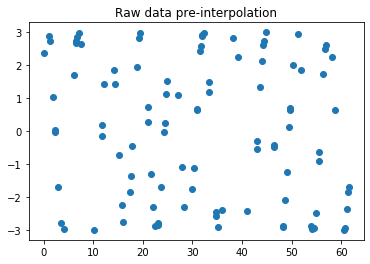

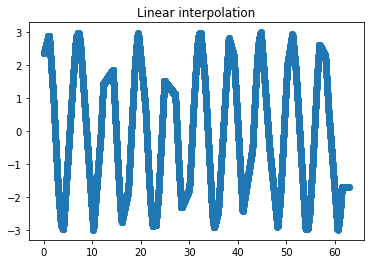

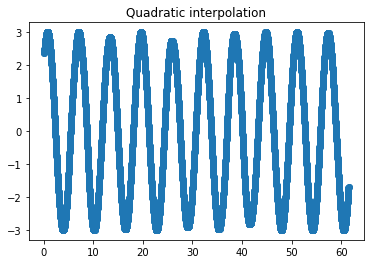

In [101]:
import matplotlib.pyplot as plt

num_periods = 10
num_reps = 10000
amp = 3
phase = np.pi / 4
x = np.linspace(0, 2*np.pi*num_periods, num=num_reps)
y = amp * np.sin(x + phase)

chosen_idx = np.random.choice(num_reps, size=100, replace=False)
data = pd.DataFrame(np.nan, index=x, columns=['raw'])
data.iloc[chosen_idx, 0] = y[chosen_idx]

# plotting
fig1, ax1 = plt.subplots()
ax1.set_title('Raw data pre-interpolation')
data.raw.plot(marker='o')
data['lin_inter'] = data.raw.interpolate(method='index')
fig2, ax2 = plt.subplots()
ax2.set_title('Linear interpolation')
data.lin_inter.plot(marker='o')
data['quad_inter'] = data.raw.interpolate(method='quadratic')
fig3, ax3 = plt.subplots()
ax3.set_title('Quadratic interpolation')
data.quad_inter.plot(marker='o')

2. _Replace Values:_ When we wish to replace values in a Series or DataFrame, we can do so in two main ways. The first, and most common, is a simple boolean masked, which we've already covered. The second method is the `.replace()` method of a Series\DataFrame.
    - Create a (10, 2) dataframe with increasing integer values 0-9 in both columns.
    - Use the `.replace()` method to replace the value 3 in the first column with 99.
    - Use it to replace 3 in column 0, and 1 in column 2, with 99.
    - Use its `method` keyword to replace values in the range [3, 6) of the first column with 6.

In [87]:
data = np.tile(np.arange(10)[:, np.newaxis], (1, 2))
df = pd.DataFrame(data)
df

,0,1
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [88]:
df.replace({0: 3}, {0: 99})

,0,1
0,0,0
1,1,1
2,2,2
3,99,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [89]:
df.replace({0: 3, 1: 1}, 99)

,0,1
0,0,0
1,1,99
2,2,2
3,99,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [90]:
df[0].replace(np.arange(3, 6), method='bfill')

0    0
1    1
2    2
3    6
4    6
5    6
6    6
7    7
8    8
9    9
Name: 0, dtype: int64

3. _MultiIndex #1:_ Construct a MultiIndex with 3 levels as the product of the following values: `(['a', b', 'c', 'd'], ['i', 'ii', 'iii'], ['x', 'y', 'z'])`. Populate the DataFrame with random values in two columns.
    - Extract in two different methods only the values with an index of `('a', 'ii', 'z')`.
    - Slice in two ways the values with an index of `'x'`.

In [120]:
letters = ['a', 'b', 'c', 'd']
roman = ['i', 'ii', 'iii']
coor = ['x', 'y', 'z']
index = pd.MultiIndex.from_product((letters, roman, coor))
data = np.random.randint(20, size=(len(letters) * len(roman) * len(coor), 2))
df = pd.DataFrame(data, columns=['today', 'tomorrow'], index=index)
df

today  tomorrow
a i   x      5        14
      y      1        11
      z      0         9
  ii  x     10        17
      y     19        12
      z      1        13
  iii x      4         1
      y     13        15
      z     15        10
b i   x     14        15
      y      3         2
      z      5         8
  ii  x      1        12
      y     18        14
      z     10        10
  iii x      2        14
      y      4        12
      z     13        11
c i   x      7        10
      y      1        19
      z     16        18
  ii  x     14         9
      y     16        13
      z      3         6
  iii x      5         5
      y     17         8
      z      5         3
d i   x      7         6
      y     11        14
      z     17         5
  ii  x      0        10
      y      0        16
      z      8        11
  iii x      3         0
      y      3        11
      z      9         3

In [92]:
# Extract specific values - 1
df.loc['a', 'ii', 'z']

today       10
tomorrow     3
Name: (a, ii, z), dtype: int64

In [93]:
# Extract specific values - 2
df.xs(key=('a', 'ii', 'z'))

today       10
tomorrow     3
Name: (a, ii, z), dtype: int64

In [94]:
# Extract specific values - 2
idx = pd.IndexSlice
df.loc[idx['a', 'ii', 'z'], :]

today       10
tomorrow     3
Name: (a, ii, z), dtype: int64

In [95]:
# Extract slice - 1
idx = pd.IndexSlice
df.loc[idx[:, :, 'x'], :]

today  tomorrow
a i   x      5        13
  ii  x      5        16
  iii x      1         5
b i   x     11        18
  ii  x      6         8
  iii x      3         2
c i   x      9        16
  ii  x      1        17
  iii x     15        13
d i   x      5         6
  ii  x      2         7
  iii x      5         1

In [96]:
# Extract slice - 2
df.xs(key='x', level=2)

today  tomorrow
a i        5        13
  ii       5        16
  iii      1         5
b i       11        18
  ii       6         8
  iii      3         2
c i        9        16
  ii       1        17
  iii     15        13
d i        5         6
  ii       2         7
  iii      5         1

3. _MultiIndex #2:_ Read the CSV from the previous class and parse at least two of its columns as indices. If you identify more columns that fit the role of an index - please make them such.
    - How many entries do you have for each index?
    - Aggregate the data based on its mean for each index level.

In [121]:
reqs = pd.read_csv(r'extra_material/311_service_requests.zip')
reqs.head()

FileNotFoundError: [Errno 2] No such file or directory: 'extra_material/311_service_requests.zip'

In [98]:
reqs.set_index(['Unnamed: 0', 'Agency', 'Complaint Type', 'Descriptor', 'Location Type', 'Bridge Highway Direction'], inplace=True)
reqs.head()

,,,,,,Unique Key,Created Date,Closed Date,Agency Name,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,...,Taxi Pick Up Location,Bridge Highway Name,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
Unnamed: 0,Agency,Complaint Type,Descriptor,Location Type,Bridge Highway Direction,,,,,,,,,,,,,,,,,,,,,
0,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19574549,01/11/2011 03:47:18 PM,07/05/2011 04:08:01 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19579718,01/11/2011 03:00:00 AM,NaN,Department of Environmental Protection,10011,226 WEST 20 STREET,WEST 20 STREET,7 AVENUE,8 AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
2,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19573881,01/11/2011 11:31:02 AM,07/05/2011 04:07:58 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEP,Lead,Lead Kit Request (Non-Residential) (L11),NaN,NaN,19579917,01/11/2011 12:46:00 PM,NaN,Department of Environmental Protection,10128,7 EAST 95 STREET,EAST 95 STREET,5 AVENUE,MADISON AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.787046,-73.955817,"(40.78704587425496, -73.95581736959971)"
4,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19580080,01/11/2011 05:03:00 PM,NaN,Department of Environmental Protection,11208,721 FOUNTAIN AVENUE,FOUNTAIN AVENUE,WORTMAN AVENUE,COZINE AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662730,-73.868878,"(40.66272996328775, -73.8688777423775)"


In [99]:
reqs.index.set_names('num', level=0, inplace=True)
reqs.head()

,,,,,,Unique Key,Created Date,Closed Date,Agency Name,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,...,Taxi Pick Up Location,Bridge Highway Name,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
num,Agency,Complaint Type,Descriptor,Location Type,Bridge Highway Direction,,,,,,,,,,,,,,,,,,,,,
0,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19574549,01/11/2011 03:47:18 PM,07/05/2011 04:08:01 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19579718,01/11/2011 03:00:00 AM,NaN,Department of Environmental Protection,10011,226 WEST 20 STREET,WEST 20 STREET,7 AVENUE,8 AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
2,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19573881,01/11/2011 11:31:02 AM,07/05/2011 04:07:58 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEP,Lead,Lead Kit Request (Non-Residential) (L11),NaN,NaN,19579917,01/11/2011 12:46:00 PM,NaN,Department of Environmental Protection,10128,7 EAST 95 STREET,EAST 95 STREET,5 AVENUE,MADISON AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.787046,-73.955817,"(40.78704587425496, -73.95581736959971)"
4,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19580080,01/11/2011 05:03:00 PM,NaN,Department of Environmental Protection,11208,721 FOUNTAIN AVENUE,FOUNTAIN AVENUE,WORTMAN AVENUE,COZINE AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662730,-73.868878,"(40.66272996328775, -73.8688777423775)"


In [100]:
# Different entries for each index
reqs.count()

Unique Key                        300000
Created Date                      300000
Closed Date                       258815
Agency Name                       300000
Incident Zip                      292510
Incident Address                  247648
Street Name                       247620
Cross Street 1                    247870
Cross Street 2                    247755
Intersection Street 1              27723
Intersection Street 2              27725
Address Type                      289396
City                              292703
Landmark                             287
Facility Type                      40574
Status                            299999
Due Date                          107631
Resolution Description            270293
Resolution Action Updated Date    286853
Community Board                   300000
Borough                           300000
X Coordinate (State Plane)        275201
Y Coordinate (State Plane)        275201
Park Facility Name                300000
Park Borough    

## _n_-Dimensional Containers

While technically a DataFrame is a two-dimensional container, in the next lesson we'll see why it can perform quite efficienty as a pseudo n-dimensional container. 

If you wish to have _true_ n-dimensional DataFrame-like data structures, you should use the `xarray` package and its `xr.DataArray` and `xr.Dataset` objects, which we'll discuss in the next lessons.